In [2]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

from google.colab import drive
import os
drive.mount('/content/gdrive/')

%cd /content/gdrive/My\ Drive/GAN/32

Found GPU at: /device:GPU:0
Mounted at /content/gdrive/
/content/gdrive/My Drive/GAN/32


In [4]:
import keras
from keras.layers import Dense, Conv2DTranspose, LeakyReLU, Reshape, BatchNormalization, Activation, Conv2D
from keras.models import Model, Sequential


def generador_de_imagenes():

    generador = Sequential()

    generador.add(Dense(256*4*4, input_shape = (100,)))
    #generador.add(BatchNormalization())
    generador.add(LeakyReLU())
    generador.add(Reshape((4,4,256)))

    generador.add(Conv2DTranspose(128,kernel_size=3, strides=2, padding = "same"))
    #generador.add(BatchNormalization())
    generador.add(LeakyReLU(alpha=0.2))


    generador.add(Conv2DTranspose(128,kernel_size=3, strides=2, padding = "same"))
    #generador.add(BatchNormalization())
    generador.add(LeakyReLU(alpha=0.2))

    generador.add(Conv2DTranspose(128,kernel_size=3, strides=2, padding = "same"))
    #generador.add(BatchNormalization())
    generador.add(LeakyReLU(alpha=0.2))

    generador.add(Conv2D(3,kernel_size=3, padding = "same", activation='tanh'))

    return(generador)

modelo_generador = generador_de_imagenes()

modelo_generador.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 4096)              413696    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 4096)              0         
                                                                 
 reshape_1 (Reshape)         (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 8, 8, 128)        295040    
 ranspose)                                                       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 16, 16, 128)      147584    
 ranspose)                                            

1/1 [==============================] - 9s 9s/step


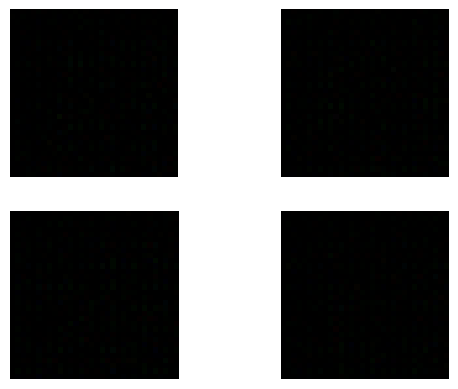

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Definir datos de entrada
def generar_datos_entrada(n_muestras):
  X = np.random.randn(100 * n_muestras)
  X = X.reshape(n_muestras, 100)
  return X

def crear_datos_fake(modelo_generador, n_muestras):
  input = generar_datos_entrada(n_muestras)
  X = modelo_generador.predict(input)
  y = np.zeros((n_muestras, 1))
  return X,y

numero_muestras = 4
X,_ = crear_datos_fake(modelo_generador, numero_muestras)

# Visualizamos resultados
for i in range(numero_muestras):
    plt.subplot(2, 2, 1 + i)
    plt.axis('off')
    plt.imshow(X[i])

In [6]:
from keras.layers import Conv2D, Flatten, Dropout
from keras.optimizers import Adam

def discriminador_de_imagenes():

    discriminador = Sequential()
    discriminador.add(Conv2D(64, kernel_size=3, padding = "same", input_shape = (32,32,3)))
    discriminador.add(LeakyReLU(alpha=0.2))
    #discriminador.add(Dropout(0.2))

    discriminador.add(Conv2D(128, kernel_size=3,strides=(2,2), padding = "same"))
    discriminador.add(LeakyReLU(alpha=0.2))
    #discriminador.add(Dropout(0.2))

    discriminador.add(Conv2D(128, kernel_size=3,strides=(2,2), padding = "same"))
    discriminador.add(LeakyReLU(alpha=0.2))
    #discriminador.add(Dropout(0.2))

    discriminador.add(Conv2D(256, kernel_size=3, strides=(2,2), padding = "same"))
    discriminador.add(LeakyReLU(alpha=0.2))
    #discriminador.add(Dropout(0.2))

    discriminador.add(Flatten())
    discriminador.add(Dropout(0.4))
    discriminador.add(Dense(1, activation='sigmoid'))

    opt = Adam(lr=0.0002 ,beta_1=0.5)
    discriminador.compile(loss='binary_crossentropy', optimizer= opt , metrics = ['accuracy'])

    return(discriminador)

modelo_discriminador = discriminador_de_imagenes()
modelo_discriminador.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 8, 8, 128)         147584    
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                                 
 conv2d_5 (Conv2D)           (None, 4, 4, 256)        

/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [7]:
import numpy as np
import cv2
import os

def cargar_imagenes():
    ruta_carpeta = '/content/gdrive/My Drive/GAN/celeba'
    imagenes = []

    for archivo in os.listdir(ruta_carpeta):
        ruta_archivo = os.path.join(ruta_carpeta, archivo)
        imagen = cv2.imread(ruta_archivo)
        imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB) # Cambiar el orden de los canales de color
        imagen = cv2.resize(imagen, (32, 32)) # Redimensionar la imagen
        imagenes.append(imagen)

    # Convertir la lista de imágenes a un array de numpy y normalizarlo
    X = np.array(imagenes).astype('float32')
    X = (X - 127.5) / 127.5

    return X


print(cargar_imagenes().shape)

(300, 32, 32, 3)


In [8]:
import random

def cargar_datos_reales(dataset, n_muestras):
  ix = np.random.randint(0, dataset.shape[0], n_muestras)
  X = dataset[ix]
  y = np.ones((n_muestras, 1))
  return X,y

def cargar_datos_fake(n_muestras):
  X = np.random.rand(32 * 32 * 3 * n_muestras)
  X = -1 + X * 2
  X = X.reshape((n_muestras, 32,32,3))
  y = np.zeros((n_muestras, 1))
  return X,y

In [9]:
def entrenar_discriminador(modelo, dataset, n_iteraciones=200, batch = 128):
  medio_batch = int(batch/2)

  for i in range(n_iteraciones):
    X_real, y_real = cargar_datos_reales(dataset, medio_batch)
    _, acc_real = modelo.train_on_batch(X_real, y_real)

    X_fake, y_fake = cargar_datos_fake(medio_batch)
    _, acc_fake = modelo.train_on_batch(X_fake, y_fake)

    print(str(i+1) + ' Real:' + str(acc_real*100) + ', Fake:' + str(acc_fake*100))

In [10]:
dataset = cargar_imagenes()
entrenar_discriminador(modelo_discriminador, dataset)

1 Real:34.375, Fake:9.375
2 Real:96.875, Fake:12.5
3 Real:100.0, Fake:40.625
4 Real:100.0, Fake:73.4375
5 Real:98.4375, Fake:96.875
6 Real:96.875, Fake:98.4375
7 Real:93.75, Fake:100.0
8 Real:100.0, Fake:100.0
9 Real:92.1875, Fake:100.0
10 Real:96.875, Fake:100.0
11 Real:96.875, Fake:100.0
12 Real:96.875, Fake:100.0
13 Real:100.0, Fake:100.0
14 Real:98.4375, Fake:100.0
15 Real:100.0, Fake:100.0
16 Real:100.0, Fake:100.0
17 Real:98.4375, Fake:100.0
18 Real:100.0, Fake:100.0
19 Real:100.0, Fake:100.0
20 Real:100.0, Fake:100.0
21 Real:100.0, Fake:100.0
22 Real:100.0, Fake:100.0
23 Real:100.0, Fake:100.0
24 Real:100.0, Fake:100.0
25 Real:100.0, Fake:100.0
26 Real:100.0, Fake:100.0
27 Real:100.0, Fake:100.0
28 Real:100.0, Fake:100.0
29 Real:100.0, Fake:100.0
30 Real:100.0, Fake:100.0
31 Real:100.0, Fake:100.0
32 Real:100.0, Fake:100.0
33 Real:100.0, Fake:100.0
34 Real:100.0, Fake:100.0
35 Real:100.0, Fake:100.0
36 Real:100.0, Fake:100.0
37 Real:100.0, Fake:100.0
38 Real:100.0, Fake:100.0
39

In [11]:
def crear_gan(discriminador, generador):
    discriminador.trainable=False
    gan = Sequential()
    gan.add(generador)
    gan.add(discriminador)

    opt = Adam(lr=0.0002,beta_1=0.5) 
    gan.compile(loss = "binary_crossentropy", optimizer = opt)

    return gan

gan = crear_gan(modelo_discriminador,modelo_generador)
gan.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 32, 32, 3)         1007363   
                                                                 
 sequential_2 (Sequential)   (None, 1)                 522497    
                                                                 
Total params: 1,529,860
Trainable params: 1,007,363
Non-trainable params: 522,497
_________________________________________________________________


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime

def mostrar_imagenes_generadas(datos_fake, epoch):

  now = datetime.now()
  now = now.strftime("%Y%m%d_%H%M%S")

  # Hacemos que los datos vayan de 0 a 1
  datos_fake = (datos_fake + 1) / 2.0

  for i in range(10):
    plt.imshow(datos_fake[i])
    plt.axis('off')
    nombre = str(epoch) + '_imagen_generada_' + str(i) + '.png'
    plt.savefig(nombre, bbox_inches='tight')

In [13]:
def evaluar_y_guardar(modelo_generador, epoch, medio_dataset):

  # Guardamos el modelo
  now = datetime.now()
  now = now.strftime("%Y%m%d_%H%M%S")
  nombre = str(epoch) + '_' + str(now)+"_modelo_generador_" + '.h5'
  modelo_generador.save(nombre)

  # Generamos nuevos datos
  X_real,Y_real = cargar_datos_reales(dataset, medio_dataset)
  X_fake, Y_fake =  crear_datos_falsos(modelo_generador,medio_dataset)

  # Evaluamos el modelo
  _, acc_real = modelo_discriminador.evaluate(X_real, Y_real)
  _, acc_fake = modelo_discriminador.evaluate(X_fake, Y_fake)

  print('Acc Real:' + str(acc_real*100) + '% Acc Fake:' + str(acc_fake*100)+'%')

In [14]:
def entrenamiento(datos, modelo_generador, modelo_discriminador, epochs, n_batch, inicio = 0):
  dimension_batch = int(datos.shape[0]/n_batch)
  medio_dataset = int(n_batch/2)

  # Iteramos para todos los epochs
  for epoch in range(inicio, inicio + epochs):
    # Iteramos para todos los batches
    for batch in range(n_batch):

      # Cargamos datos reales
      X_real,Y_real = cargar_datos_reales(dataset, medio_dataset)


      # Enrenamos discriminador con datos reales
      coste_discriminador_real, _ = modelo_discriminador.train_on_batch(X_real, Y_real)
      X_fake, Y_fake =  crear_datos_fake(modelo_generador,medio_dataset)

      coste_discriminador_fake, _ = modelo_discriminador.train_on_batch(X_fake, Y_fake)

      # Generamos datos de entadas de la GAN
      X_gan = generar_datos_entrada(medio_dataset)
      Y_gan = np.ones((medio_dataset, 1))

      # Entrenamos la GAN con datos falsos
      coste_gan = gan.train_on_batch(X_gan, Y_gan)

    print('Epoch: ' + str(epoch))
    # Cada 10 Epochs mostramos resultados y el coste
    if (epoch+1) % 10 == 0:
      evaluar_y_guardar(modelo_generador,epoch = epoch, medio_dataset= medio_dataset)
      mostrar_imagenes_generadas(X_fake, epoch = epoch)

Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 5ms/step
Epoch: 151
2/2 [==============================] - 0s 10ms/step
Epoch: 152
2/2 [==============================] - 0s 7ms/step
Epoch: 153
2/2 [==============================] - 0s 6ms/step
Epoch: 154
2/2 [==============================] - 0s 7ms/step
Epoch: 155
2/2 [==============================] - 0s 16ms/step
Epoch: 156
2/2 [==============================] - 0s 6ms/step
Epoch: 157
2/2 [==============================] - 0s 6ms/step
Epoch: 158
2/2 [==============================] - 0s 5ms/step
Epoch: 159
2/2 [==============================] - 0s 13ms/step - loss: 2.7529e-04 - accuracy: 1.0000
Acc Real:100.0% Acc Fake:100.0%
2/2 [==============================] - 0s 9ms/step
Epoch: 160
2/2 [==============================] - 0s 14ms/step
Epoch: 161
2/2 [==============================] - 0s 10ms/step
Epoch: 162
2/2 [==============================] - 0s 6ms/step
Epoch: 163
2/2 [============

KeyboardInterrupt: ignored

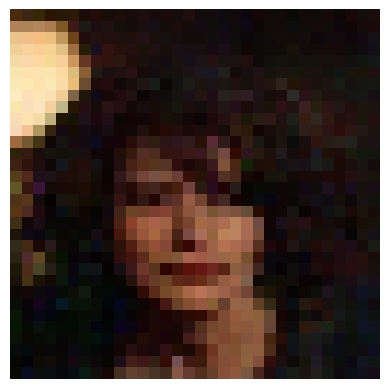

In [22]:
entrenamiento(dataset, modelo_generador, modelo_discriminador, epochs = 1000, n_batch=128, inicio = 0)

In [15]:
modelo_generador.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [60]:
# 2. Importamos el modelo
from keras.models import load_model

modelo_generador = load_model('179_20230402_185110_modelo_generador_.h5')

2/2 [==============================] - 0s 6ms/step


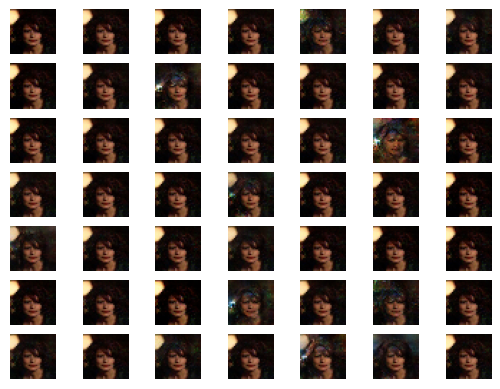

In [62]:
X_fake, _ = crear_datos_fake(n_muestras=49, modelo_generador=modelo_generador)
X_fake = (X_fake+1)/2

for i in range(49):
  plt.subplot(7,7,i+1)
  plt.axis('off')
  plt.imshow(X_fake[i])